<a href="https://colab.research.google.com/github/kiran74-ds/reinforcement_learning/blob/master/Cart_pole_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
import gym
import numpy as np
import cv2
from collections import deque

In [149]:
env = gym.make('CartPole-v1')

In [153]:
env.observation_space

Box(4,)

In [154]:
env.action_space.n

2



```
# This is formatted as code


Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right

```









In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)
        
    def forward(self, state):
       
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [205]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Agent():
    def __init__(self, state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(0)

        ## hyperparameters
        self.buffer_size = 2000
        self.batch_size = 64
        self.gamma = 0.99
        self.lr = 0.0025
        self.update_every = 4        

        # Q-Network
        self.local = DQNetwork(state_size, action_size).to(device)
        self.target = DQNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.local.parameters(), lr=self.lr)

        # Replay memory
        self.memory = deque(maxlen=self.buffer_size)  
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        # Initialize time step (for updating every few steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
        # Learn every update_every time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.sample_experiences()
                self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        # Epsilon-greedy action selection
        if random.random() > eps:
          state = torch.from_numpy(state).float().unsqueeze(0).to(device)
          self.local.eval()
          with torch.no_grad():
            action_values = self.local(state)
          self.local.train()
          return np.argmax(action_values.cpu().data.numpy())
        else:
          return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        
        states, actions, rewards, next_states, dones = experiences
       # Get expected Q values from local model
        Q_expected = self.local(states).gather(1, actions)

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.update_target_model()                  


    def update_target_model(self):
        self.target.load_state_dict(self.local.state_dict())

    def sample_experiences(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)




In [225]:
def dqn(n_episodes=200, max_t=5000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        score = 0
        for i in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _  = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -10
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tReward {} \tAverage Score: {:.2f} \tEpsilon: {}'.format(i_episode,score,np.mean(scores_window), eps), end="")
        if i_episode % 100 == 0:
          print('\rEpisode {}\tAverage Score: {:.2f} \tEpsilon: {}'.format(i_episode, np.mean(scores_window), eps))
    return scores

In [226]:
agent = Agent(env.observation_space.shape[0], env.action_space.n)

In [227]:
scores = dqn(n_episodes=500)

Episode 100	Average Score: 28.96 	Epsilon: 0.6057704364907278
Episode 200	Average Score: 117.73 	Epsilon: 0.3669578217261671
Episode 300	Average Score: 344.13 	Epsilon: 0.22229219984074702
Episode 400	Average Score: 228.71 	Epsilon: 0.1346580429260134
Episode 500	Average Score: 275.56 	Epsilon: 0.08157186144027828


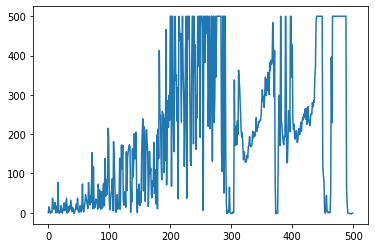

In [228]:
plt.plot(scores)